# Deep Learning for Aspect-Based Sentiment Analysis  

Using performance achieved through an implementation as described in the paper [Deep Learning for Aspect-Based Sentiment Analysis](https://cs224d.stanford.edu/reports/WangBo.pdf), this notebooks explores an alternative approach where we will use RNN's to extract context from a sentence rather than the average of the word embeddings. 

## References   
**SemEval-2015** http://alt.qcri.org/semeval2015/task12/

In [1]:
import os
import sys
import json 
import datetime
import random 
import pickle 
import collections 
import itertools
import copy
import operator
import re
import time 
import xml.etree.ElementTree
from string import punctuation
import numpy as np
import pandas as pd

# LDA, tSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from gensim.models.ldamodel import LdaModel
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, precision_recall_fscore_support

# NLTK
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer

# TensorFlow / Keras 
import h5py
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Input, layers, activations, models
from tensorflow.keras import callbacks

import tensorflow.keras.backend as K

# Plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# NLP (new tool)
#from textblob import TextBlob # tutorial http://textblob.readthedocs.io/en/dev/quickstart.html

In [2]:
sns.set(style="whitegrid")
_ = np.seterr(divide='ignore', invalid='ignore')

## Load Data

In [3]:
def load_file(filename):
    elem_root = xml.etree.ElementTree.parse(filename).getroot()
    
    reviews = []

    for review_elem in elem_root:
        for sentence_elem in review_elem.find('sentences'):
            sentence = sentence_elem.find('text').text

            opinions = [] 

            opinions_elem = sentence_elem.find('Opinions')
            if opinions_elem is not None:
                for opinion_elem in sentence_elem.find('Opinions'):
                    category = opinion_elem.attrib['category']
                    polarity = opinion_elem.attrib['polarity']
                    target = opinion_elem.attrib['target']
                    target_from = int(opinion_elem.attrib['from']) 
                    target_to = int(opinion_elem.attrib['to']) 

                    entity = category.split('#')[0].lower() 
                    attribute = category.split('#')[1].lower()
                    opinions.append({
                        'category': category.lower(), 
                        'sentiment': polarity, 
                        'target': target.lower(), 
                        'from': target_from, 
                        'to': target_to
                    })

            reviews.append({
                'sentence': sentence, 
                'opinions': opinions
            })

    print("Finished parsing XML document with {} reviews".format(len(reviews)))
    return reviews 

In [11]:
all_reviews = load_file('data/ABSA15_Hotels_Test.xml')

Finished parsing XML document with 266 reviews


**NB: I had only trained this model on the restaurants data (ABSA-15_Restaurants_Train_Final.xml and ABSA-15_Restaurants_Train_Test.xml for validation). I hadn't realised how *SMALL* this dataset is; you may want to train it with the restaurants data then retrain the same model with this dataset - same approach applies** 

In [12]:
np.random.shuffle(all_reviews)

split = int(len(all_reviews) * .9)

train_reviews = all_reviews[:split]
test_reviews = all_reviews[split:]

print("number of reviews for training {}, number of reviews for testing {}".format(len(train_reviews), len(test_reviews)))

number of reviews for training 239, number of reviews for testing 27


In [13]:
train_reviews[:2]

[{'sentence': 'DO NOT STAY HERE',
  'opinions': [{'category': 'hotel#general',
    'sentiment': 'negative',
    'target': 'null',
    'from': 0,
    'to': 0}]},
 {'sentence': 'She tried to refuse my gold crown club points as payment for my stay.',
  'opinions': [{'category': 'service#general',
    'sentiment': 'negative',
    'target': 'null',
    'from': 0,
    'to': 0}]}]

## Sentence preprocessing

In [14]:
test_sentence = train_reviews[0]['sentence']

In [15]:
def clean_sentence(sentence):
    # lower case 
    sentence = sentence.lower()            
    
    return sentence

print(clean_sentence(test_sentence))

do not stay here


In [16]:
tb_word_tokenizer = TreebankWordTokenizer()

def tokenise_sentence(sentence):
    return tb_word_tokenizer.tokenize( clean_sentence(sentence))

print(tokenise_sentence(test_sentence)) 

['do', 'not', 'stay', 'here']


In [18]:
"""
To get a list of all possible POS 
nltk.help.upenn_tagset()
"""
from tensorflow.keras.utils import to_categorical

POS = [
    'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 
    'NNP', 'NNPS' 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 
    'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 
    'UNK', # UNKNOWN
    'NA' # NONE (for padding)
]

POS_index = {pos : i for i, pos in enumerate(POS)}

index_POS = {i : pos for i, pos in enumerate(POS)}

pos_one_hot_encoding = to_categorical([POS_index[pos] for pos in POS])

def get_pos_from_sentence(sentence_tokens):    
    if type(sentence_tokens) is not list:
        raise Exception('The get_pos_from_sentence function requires a list of tokens')            
        
    sentence_pos = nltk.pos_tag(sentence_tokens)
    return [pos[1] if pos[1] in POS else 'UNK' for pos in sentence_pos]

def get_pos_encoding_from_sentence(sentence_tokens):
    return np.array(
        [pos_one_hot_encoding[POS_index[pos]] for pos in get_pos_from_sentence(sentence_tokens)], dtype=np.int
    )

print("POS Tags from test sentence")
print(get_pos_from_sentence(tokenise_sentence(test_sentence)))

POS Tags from test sentence
['VB', 'RB', 'VB', 'RB']


### Build up vocabulary

In [20]:
TAGS = {'<PAD>': 0, '<UNK>': 1, }

In [21]:
all_sentences = [review['sentence'] for review in train_reviews] + [review['sentence'] for review in test_reviews]
print("Sentences count {}".format(len(all_sentences)))

Sentences count 266


In [22]:
word_counts = {}
for sentence in all_sentences:
    tokens = tokenise_sentence(sentence)
    for token in tokens:
        if token not in word_counts:
            word_counts[token] = 0 
        word_counts[token] += 1 

print("Corpus has {} unique words".format(len(word_counts)))

Corpus has 890 unique words


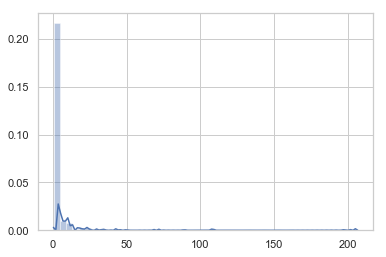

In [23]:
sns.distplot([count for word, count in word_counts.items()])

In [28]:
# lets limit it to words that occured at least twice (adding on the number of tags we'll use)
#vocab_size = sum(1 for word, count in word_counts.items() if count > 3) + len(TAGS)

## NB Because we're using embeddings; we'll include every word (expect this to drag down performance)
vocab_size = len(word_counts) + len(TAGS)

print("Vocab size {}".format(vocab_size))

Vocab size 892


In [29]:
vocab = sorted(word_counts.items(), key=lambda kv: kv[1], reverse=True)[:vocab_size]

In [30]:
# print some stats
print("vocab size {}, most frequent word '{}' ({}), least freqent word = '{}' ({})".format(
    len(vocab), vocab[0][0], vocab[0][1], vocab[-1][0], vocab[-1][1]))

vocab size 890, most frequent word '.' (206), least freqent word = 'choice' (1)


In [31]:
# create index_2_word and word_2_index lookups 
word_index = copy.copy(TAGS)

for v_i, v in enumerate(vocab, len(TAGS)):
    word_index[v[0]] = v_i

index_word = {v_i: v for v, v_i in word_index.items()}

In [32]:
print("First 20 words in our index")
for i in range(20):
    print("{} = {}".format(i, index_word[i]))

First 20 words in our index
0 = <PAD>
1 = <UNK>
2 = .
3 = the
4 = was
5 = and
6 = ,
7 = to
8 = i
9 = a
10 = hotel
11 = in
12 = for
13 = it
14 = this
15 = very
16 = of
17 = is
18 = !
19 = great


## Create Embedding Matrix (GloVe)

In [35]:
def create_embedding_matrix(filename, word_index=None, max_words=-1):
    """
    @param word_index: setting word_index is None will create an index 
    @param max_words: setting word_index > 0 will limit the number of words created 
    """

    print("Creating embedding matrix form {}".format(filename))    
    # create embedding matrix 
    creating_word_index = word_index is None         
    
    if creating_word_index:
        word_index = copy.copy(TAGS)        
        
    embedding_size = -1
    
    embeddings_index = {}
    with open(filename, encoding='utf-8') as f:
        for line_index, line in enumerate(f):
            values = line.split() 
            word = values[0].lower() 
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs    
            
            if embedding_size == -1:
                embedding_size = len(coefs)
            
            if creating_word_index:
                word_index[word] = len(word_index.keys())                 
                
            if max_words > 0 and line_index >= max_words:
                break 
    
    vocab_size = len(word_index.keys()) + 1
    
    print("Vocab size {}, Embedding size {}".format(vocab_size, embedding_size))
    
    # TODO: limit to a pre-defined vocabulary? 
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float)
    
    for word, idx in word_index.items():
        embedding_vector = embeddings_index.get(word)
            
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            embedding_vector = np.zeros((embedding_size), dtype=np.float)
            #embedding_vector[idx] = 0.5 # create some arbitary vector 
            embedding_matrix[idx] = embedding_vector
    
    print("Finished creating embedding matrix with shape {}".format(embedding_matrix.shape))
    
    return word_index, embedding_matrix

In [37]:
# We'll pass in null to create a vocab to include 
word_index, embedding_matrix = create_embedding_matrix(
    '/Users/Joshua.Newnham/Dropbox/Shared/glove.42B.300d.txt', None, -1)

Creating embedding matrix form /Users/Joshua.Newnham/Dropbox/Shared/glove.42B.300d.txt
Vocab size 1917497, Embedding size 300
Finished creating embedding matrix with shape (1917497, 300)


### Save word_index and embedding matrix

In [39]:
with open('exports/word_index.json', 'w') as f:
    word_index_json = json.dumps(word_index)
    f.write(word_index_json)

In [40]:
with open('exports/embedding_matrix.np', 'wb') as f:
    np.save(f, embedding_matrix)

Let's now create functions to convert a sentence to vectors which we can feed into our model... Following the paper we will create a single vector for each setnence by the embedding size where the vector will be represented as the average of all the words within the sentence.

In [41]:
MAX_SEQ_LEN = 20

In [42]:
def pad_sequences(seq, maxlen=MAX_SEQ_LEN):
    if len(seq) == maxlen:
        return seq 
    
    if len(seq) > maxlen:
        return seq[:maxlen]
    
    # length is shorter - need to pad out 
    diff = maxlen - len(seq)
    
    return ([0] * diff) + seq  

In [43]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def encode_sentence(sentence, word_index, embedding_matrix, maxlen=MAX_SEQ_LEN):        
    #print('encoding sentence :: {}'.format(sentence))        
    
    # tokensise     
    tokens = tokenise_sentence(sentence)
    
    # vectorise 
    vec = [int(word_index[token]) if token in word_index else word_index['<UNK>'] for token in tokens]
    
    # pad 
    vec = pad_sequences(vec, maxlen)    
    
    # create our encoded sentence vector 
    encoded_sentence = np.zeros((maxlen, embedding_matrix.shape[1]), dtype=np.float)
    
    # Get each words embeddings for each word 
    # and add it to our encoded_sentence vector 
    for i, v in enumerate(vec):
        encoded_sentence[i] = embedding_matrix[v]        
        
    ### post-fix (POS) 
    
    # Now create the POS post-fix 
    pos = get_pos_encoding_from_sentence(tokens)
    
    # create our encoded sentence vector 
    encoded_pos = np.zeros((maxlen, pos.shape[1]), dtype=np.float)
    for i in range(min(maxlen, pos.shape[0])):
        encoded_pos[i] = pos[i]            
    
    return np.concatenate((encoded_sentence, encoded_pos), axis=1)

In [44]:
def encode_sentences(sentences, word_index, embedding_matrix):
    return np.array([encode_sentence(sentence, word_index, embedding_matrix) for sentence in sentences])

In [45]:
test_sentence_encoding = encode_sentence(test_sentence, word_index, embedding_matrix)
print(test_sentence_encoding.shape)

(20, 337)


--- 

## Label Encoding

encode expressed aspect terms using the IOB2 tagging scheme [31]. According to this scheme, each word in our text receives one of 3 tags, namely I, O or B that indicate if the word is at the **Beginning**, **Inside** or **Outside** of an annotation:
<img src='images/bio_1.png' width='500px' />

This tagging scheme allows us to encode multiple non-overlapping aspect terms
at once. Ultimately, each tag is represented as a 1-of-K vector:
<img src='images/bio_2.png' width='400px' />

We design a neural network based sequence tagger that reads in a sequence of words and predicts a sequence of corresponding IOB2 tags that encode the detected aspect terms.
<img src='images/bio_3.png' width='400px' />


In [47]:
IOB2_index = {
    'I' : 0, 
    'O' : 1, 
    'B' : 2
}

index_IOB2 = {
    0 : 'I', 
    1 : 'O', 
    2 : 'B'
}

IOB2_encoding = np.array([
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1]
], dtype=np.int)

In [51]:
train_reviews[2]

{'sentence': 'Interior corridors clean and well lit.',
 'opinions': [{'category': 'hotel#cleanliness',
   'sentiment': 'positive',
   'target': 'interior corridors',
   'from': 0,
   'to': 18},
  {'category': 'hotel#design_features',
   'sentiment': 'positive',
   'target': 'interior corridors',
   'from': 0,
   'to': 18}]}

In [54]:
def get_iob2_index(sentence_tokens, from_pos, to_pos):
    tag_index = []
    
    if abs(from_pos - to_pos) <= 0:
        return tag_index
    
    current_idx = 0 
    for i, token in enumerate(sentence_tokens):
        if current_idx >= from_pos and current_idx <= to_pos:
            tag_index.append(i) 
            
        current_idx += 1 + len(token)
        
    return tag_index

print(get_iob2_index(tokenise_sentence(train_reviews[2]['sentence']), 
                     train_reviews[2]['opinions'][0]['from'], 
                     train_reviews[2]['opinions'][0]['to']))

[0, 1]


In [55]:
def label_sentence(reviews, maxlen=MAX_SEQ_LEN):
    # create our encoded sentence vector 
    labels = np.zeros((len(reviews), maxlen, 3), dtype=np.int)
    
    for i, review in enumerate(reviews):            
        tokenized_sentnece = tokenise_sentence(review['sentence'])
        
        # 'reset' labels
        for j in range(maxlen):
            labels[i,j,:] = IOB2_encoding[IOB2_index['O']]
            
        for opinion in review['opinions']:
            from_pos = int(opinion['from']) 
            to_pos = int(opinion['to'])
            if abs(from_pos - to_pos) > 0:                
                labeled_indicies = get_iob2_index(tokenized_sentnece, from_pos, to_pos)
                if len(labeled_indicies) > 0:                    
                    if labeled_indicies[0] < maxlen:                        
                        labels[i,labeled_indicies[0],:] = IOB2_encoding[IOB2_index['B']]
                        
                        for j in range(1, len(labeled_indicies)):
                            if labeled_indicies[j] < maxlen:
                                labels[i,labeled_indicies[j],:] = IOB2_encoding[IOB2_index['I']]            
        
    return labels

In [56]:
print(train_reviews[15:16])
print(label_sentence(train_reviews[15:16]))

[{'sentence': 'I would say they are the best part of the hotel!', 'opinions': [{'category': 'service#general', 'sentiment': 'positive', 'target': 'null', 'from': 0, 'to': 0}]}]
[[[0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]]]


## Label Encoding Category

In [57]:
train_reviews[2]

{'sentence': 'Interior corridors clean and well lit.',
 'opinions': [{'category': 'hotel#cleanliness',
   'sentiment': 'positive',
   'target': 'interior corridors',
   'from': 0,
   'to': 18},
  {'category': 'hotel#design_features',
   'sentiment': 'positive',
   'target': 'interior corridors',
   'from': 0,
   'to': 18}]}

Categories:
Num catgories 28
Min 1
Max 53
Avg 10.857142857142858


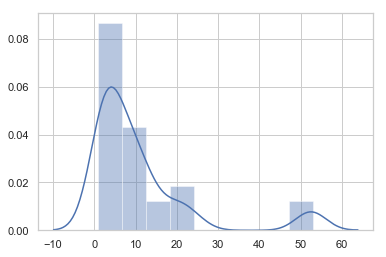

In [58]:
categories_count = {}

for review in train_reviews:
    for opinion in review['opinions']:
        category = opinion['category']
        if category not in categories_count:
            categories_count[category] = 0 
            
        categories_count[category] += 1
        
sns.distplot(list(categories_count.values()))

print("Categories:\nNum catgories {}\nMin {}\nMax {}\nAvg {}".format(
    len(categories_count), 
    min(list(categories_count.values())), 
    max(list(categories_count.values())), 
    sum(list(categories_count.values()))/len(categories_count))) 

**NB: You should ensure that you have sufficent enough examples** 
len([item for item in list(categories_count.values()) if item > 5])

In [79]:
threshold = 5
category_mapping = {key : key if count > threshold else 'OTHER' for key, count in categories_count.items()}

In [80]:
# encoding 
category_index = {cat : i for i, cat in enumerate(list(set(category_mapping.values())))}
index_category = {i : cat for i, cat in enumerate(list(set(category_mapping.values())))}

In [81]:
category_encoding = [] 

for i in index_category.keys():
    encoding = np.zeros((len(index_category)), dtype=np.int)
    encoding[i] = 1
    category_encoding.append(encoding)
    
category_encoding = np.array(category_encoding)
print(category_encoding)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [82]:
def encode_aspect(review, category_mapping, category_index):
    """
    one-hot-encoding for a given aspect
    """
    encoded_aspect = np.zeros((len(index_category),), dtype=np.float)
    
    for opinion in review['opinions']:
        category = opinion['category']
        category = category_mapping[category]
        
        cat_idx = category_index[category]
        encoded_aspect[cat_idx, ] = 1.0         
        
    return encoded_aspect

In [83]:
def encode_aspects(reviews, category_mapping, category_index):
    return np.array([encode_aspect(review, category_mapping, category_index) for review in reviews], dtype=np.float)

In [84]:
print(encode_aspect(train_reviews[0], category_mapping, category_index))

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Export 

In [85]:
with open('exports/index_category.json', 'w') as f:
    json_str = json.dumps(index_category)
    f.write(json_str)    

In [86]:
with open('exports/category_index.json', 'w') as f:
    json_str = json.dumps(category_index)
    f.write(json_str)  

## Create training and testing sets

In [87]:
train_x = encode_sentences(sentences=[review['sentence'] for review in train_reviews], 
                           word_index=word_index, 
                           embedding_matrix=embedding_matrix)

In [88]:
test_x = encode_sentences(sentences=[review['sentence'] for review in test_reviews], 
                           word_index=word_index, 
                           embedding_matrix=embedding_matrix)

In [89]:
train_y = label_sentence(train_reviews)

In [90]:
test_y = label_sentence(test_reviews)

In [91]:
train_cat_y = encode_aspects(train_reviews, category_mapping, category_index)

In [92]:
test_cat_y = encode_aspects(test_reviews, category_mapping, category_index)

In [93]:
print("Training :: X shape {} Y shape {} {}".format(train_x.shape, train_y.shape, train_cat_y.shape))
print("Testing :: X shape {} Y shape {} {}".format(test_x.shape, test_y.shape, test_cat_y.shape))

Training :: X shape (239, 20, 337) Y shape (239, 20, 3) (239, 15)
Testing :: X shape (27, 20, 337) Y shape (27, 20, 3) (27, 15)


## Create model 

In [94]:
import h5py

from tensorflow.keras import Input, layers, activations, models, optimizers, losses, optimizers
from tensorflow.keras import callbacks

import tensorflow.keras.backend as K

In [96]:
def create_model(input_shape=(MAX_SEQ_LEN, 337), num_labels=3, num_categories=15, lstm_hidden_units=20):     
        
    x_input = layers.Input(shape=input_shape, dtype='float')        
        
    lstm_output = layers.Bidirectional(
        layers.GRU(
            lstm_hidden_units, 
            recurrent_dropout=0.2, 
            return_sequences=True), 
        merge_mode='concat')(x_input)
    
    lstm_output = layers.BatchNormalization()(lstm_output)
    
    output_a = layers.TimeDistributed(
        layers.Dense(num_labels, activation=activations.softmax), 
        name='term_output')(lstm_output)    
    
    # category output 
    x_b = layers.Flatten()(lstm_output)
    x_b = layers.Dropout(0.5)(x_b)    
    cat_output = layers.Dense(num_categories, activation=None)(x_b) 
    cat_output = layers.Activation(activations.sigmoid, name='cat_output')(cat_output)
    
    model = models.Model(inputs=x_input, outputs=[output_a, cat_output])                      
    
    return model        

In [97]:
model = create_model() 

# optimizers.RMSprop()

model.compile(
    optimizer=optimizers.Adam(), 
    loss={
        'term_output': losses.categorical_crossentropy, 
        'cat_output': losses.binary_crossentropy
    })  

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 337)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 40)       42960       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 40)       160         bidirectional[0][0]              
__________________________________________________________________________________________________
flatten (Flatten)               (None, 800)          0           batch_normalization[0][0]        
__________________________________________________________________________________________________
dropout (D

## Training 

In [98]:
def plot_history(history):
    #train_acc = history.history['acc']
    #val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    data = {
        'loss': [], 
        'epoch': [], 
        'source' : []
    }
    
    for epoch, loss in enumerate(train_loss):
        data['epoch'].append(epoch)
        data['loss'].append(loss)
        data['source'].append('train')
    
    for epoch, loss in enumerate(val_loss):
        data['epoch'].append(epoch)
        data['loss'].append(loss)
        data['source'].append('valid')

    # Plot the responses for training and validation 
    sns.lineplot(x="epoch", 
                 y="loss",
                 hue="source", 
                 data=data)

In [101]:
checkpoint = callbacks.ModelCheckpoint(
    'exports/aspect_term_model.h5', 
    monitor='val_term_output_loss',
    verbose=0, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto', 
    period=2)
    
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15)
    
history = model.fit(
    train_x, [train_y, train_cat_y], 
    validation_data=(test_x, [test_y, test_cat_y]), 
    epochs=1000, 
    batch_size=32, 
    callbacks=[checkpoint, early_stopping], 
    verbose=0)

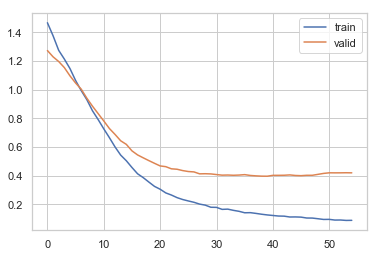

In [102]:
plot_history(history)

## Testing 

In [103]:
def predict(reviews, index, embedding_matrix, word_index, model, 
            threshold=0.4, is_logging=True, aspect_cm=None):
    """
    params: 
    """
    
    def get_tagged_words(review):
        tokens = tokenise_sentence(review['sentence'])
        words = [] 
        for opinion in review['opinions']:
            opinion_words = []
            indicies = get_iob2_index(tokens, 
                                      opinion['from'], opinion['to'])
            
            for index in indicies:
                opinion_words.append(tokens[index])
                
            if len(opinion_words) > 0:
                words.append(opinion_words)
                
        return words 
    
    def get_aspects(review):
        review_aspects = []
        
        for opinion in review['opinions']:
            review_aspects.append(opinion['category'])
        
        return review_aspects
    
    sentence = reviews[index]['sentence']
    tagged_words = get_tagged_words(reviews[index])    
    
    x = encode_sentence(sentence, 
                        embedding_matrix=embedding_matrix, 
                        word_index=word_index)
    
    predictions = model.predict(np.expand_dims(x, axis=0))
    prediction = predictions[0][0]
    prediction_indicies = [np.argmax(prediction[i]) for i in range(len(prediction))]
    
    if is_logging:
        print(sentence)
        print("Expected values")
        print("\tTagged words: {}".format(tagged_words))
        print("\tAspects: {}".format(get_aspects(reviews[index])))
    
    tokens = tokenise_sentence(sentence)
    predicted_terms = [] 
    current_prediction_terms = []
    for i in range(len(prediction_indicies)):
        if i >= len(tokens):
            break 
        if prediction_indicies[i] == 1:
            if len(current_prediction_terms) > 0:
                predicted_terms.append(current_prediction_terms)
                current_prediction_terms = [] 
        elif prediction_indicies[i] == 2:
            current_prediction_terms.append(tokens[i])
        elif prediction_indicies[i] == 0:
            current_prediction_terms.append(tokens[i])
            
    if len(current_prediction_terms) > 0:
        predicted_terms.append(current_prediction_terms)
    
    if is_logging: 
        print("Predictions")
        print("\tTagged words: {} ({})".format(predicted_terms, prediction_indicies))
    
    # extract aspects 
    aspects_probs = predictions[1][0]
    aspects = []     
    for i, prob in enumerate(aspects_probs):
        if prob > threshold:
            aspects.append("{} ({})".format(index_category[i], str(prob)[:4]))
            
    if is_logging:
        print("\tAspects: {}".format(aspects))
        
    
    # update cm 
    if aspect_cm is not None:
        expected_aspects = get_aspects(reviews[index])
        predicted_asepcts = [index_category[i] for i, prob in enumerate(aspects_probs) if prob >= threshold]                            
            
        for aspect in index_category.values():
            in_actual = aspect in expected_aspects
            in_predicted = aspect in predicted_asepcts
            
            """
            True Positives (TP) - These are the correctly predicted positive values which means 
            that the value of actual class is yes and the value of predicted class is also yes. 
            E.g. if actual class value indicates that this passenger survived and predicted class 
            tells you the same thing.
            
            True Negatives (TN) - These are the correctly predicted negative values which means 
            that the value of actual class is no and value of predicted class is also no. 
            E.g. if actual class says this passenger did not survive and 
            predicted class tells you the same thing.
            
            False Positives (FP) – When actual class is no and predicted class is yes. 
            E.g. if actual class says this passenger did not survive but predicted class tells you 
            that this passenger will survive.
            
            False Negatives (FN) – When actual class is yes but predicted class 
            in no. E.g. if actual class value indicates that this passenger survived 
            and predicted class tells you that passenger will die.            
            """
            
            if in_actual and in_predicted:
                aspect_cm[0,0] += 1
            elif not in_actual and not in_predicted:
                aspect_cm[1,1] += 1
            elif in_actual and not in_predicted:
                aspect_cm[0,1] += 1
            elif not in_actual and in_predicted:
                aspect_cm[1,0] += 1
                
    return aspect_cm

In [104]:
def calc_metrics(cm):
    """
    Accuracy = TP+TN/TP+FP+FN+TN
    Precision = TP/TP+FP
    Recall = TP/TP+FN 
    F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    """
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[1,0]
    FN = cm[0,1]
    
    accuracy = float(TP + TN)/float(TP+FP+FN+TN)
    precision = float(TP)/float(TP+FP)
    recall = float(TP)/float(TP+FN)
    f1 = (2. * recall * precision)/(recall + precision)
    
    false_negative_rate = float(FN) / float(FN + TP)    
    false_positive_rate = float(FP) / float(FP + TN)

    return {
        'accuracy':accuracy, 
        'precision':precision, 
        'recall':recall, 
        'f1':f1, 
        'false_negative_rate':false_negative_rate, 
        'false_positive_rate':false_positive_rate
    }

In [105]:
train_reviews[10]

{'sentence': 'The staff was very courteous upon check-in.',
 'opinions': [{'category': 'service#general',
   'sentiment': 'positive',
   'target': 'staff',
   'from': 4,
   'to': 9}]}

In [106]:
predict(train_reviews, 10, embedding_matrix, word_index, model)

The staff was very courteous upon check-in.
Expected values
	Tagged words: [['staff']]
	Aspects: ['service#general']
Predictions
	Tagged words: [['staff']] ([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
	Aspects: ['service#general (0.99)']


In [107]:
predict(train_reviews, 223, embedding_matrix, word_index, model)

The only nice thing was the free shuttle to America West Arena.
Expected values
	Tagged words: [['shuttle']]
	Aspects: ['facilities#prices', 'hotel#general']
Predictions
	Tagged words: [] ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
	Aspects: ['hotel#general (0.88)', 'facilities#prices (0.91)']


In [110]:
predict(test_reviews, 0, embedding_matrix, word_index, model)

The food from the restaurant was very good but pricey which was the standard for everything in this hotel.
Expected values
	Tagged words: [['food'], ['food'], ['hotel']]
	Aspects: ['food_drinks#quality', 'food_drinks#prices', 'hotel#prices']
Predictions
	Tagged words: [] ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
	Aspects: ['service#general (0.48)', 'hotel#general (0.57)']


In [114]:
predict(test_reviews, 10, embedding_matrix, word_index, model)

One time the employee stopped to pick up dirty plates as he led me to my seat!
Expected values
	Tagged words: [['employee']]
	Aspects: ['service#general']
Predictions
	Tagged words: [] ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
	Aspects: ['service#general (0.69)']


In [116]:
aspect_cm = np.zeros((2,2), dtype=np.int)

for i in range(len(train_reviews)):
    aspect_cm = predict(train_reviews, i, embedding_matrix, word_index, model, threshold=0.3, aspect_cm=aspect_cm, is_logging=False)
    
print(calc_metrics(aspect_cm))

{'accuracy': 0.9894002789400279, 'precision': 0.8701754385964913, 'recall': 0.9959839357429718, 'f1': 0.9288389513108614, 'false_negative_rate': 0.004016064257028112, 'false_positive_rate': 0.011091127098321343}


In [117]:
aspect_cm = np.zeros((2,2), dtype=np.int)

for i in range(len(test_reviews)):
    aspect_cm = predict(test_reviews, i, embedding_matrix, word_index, model, threshold=0.3, aspect_cm=aspect_cm, is_logging=False)
    
print(calc_metrics(aspect_cm))    

{'accuracy': 0.9259259259259259, 'precision': 0.375, 'recall': 0.375, 'f1': 0.375, 'false_negative_rate': 0.625, 'false_positive_rate': 0.03937007874015748}


In [118]:
prediction = model.predict(train_x)[0]

expected = [np.argmax(item_b) for item in train_y for item_b in item]
prediction = [np.argmax(item_b) for item in prediction for item_b in item]

score = precision_recall_fscore_support(expected, prediction, average='macro')

print("training set: score precision {}, recall {}, f1 {}".format(score[0], score[1], score[2]))

training set: score precision 0.9566801290217657, recall 0.6399705336842377, f1 0.7405944674781323


In [119]:
prediction = model.predict(test_x)[0]

expected = [np.argmax(item_b) for item in test_y for item_b in item]
prediction = [np.argmax(item_b) for item in prediction for item_b in item]

score = precision_recall_fscore_support(expected, prediction, average='macro')

print("test set: score precision {}, recall {}, f1 {}".format(score[0], score[1], score[2]))

test set: score precision 0.31719428926132837, recall 0.33138780804150453, f1 0.3241357437361243


### Save model weights and model architecture 

In [120]:
model.save_weights('exports/aspect_extraction.h5')

In [123]:
# save as JSON
json_string = model.to_json()
with open('exports/aspect_extraction.json', 'w') as f:
    f.write(json_string)